In [11]:
from glob import iglob
from datetime import datetime
from itertools import chain, repeat
from functools import reduce, partial

import numpy as np
import pandas as pd
from cytoolz import compose, reduce
from h5py import File
from dask import delayed, compute
from dask.bag import from_sequence
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

In [12]:
def is_available(filename):
    try:
        with File(filename, 'r'):
            pass
        return True
    except Exception:
        return False


def read_scala(filename, tag_offset = None):
    if tag_offset is None:
        where = slice(None)
    else:
        where = slice(tag_offset, None)
    with File(filename, 'r') as f:
        try:
            for tag, iom, img, dt in zip(
                f['/bunches'][where],
                f['/photon_diagnostics/FEL01/I0_monitor/iom_sh_a_pc'][where],
                f['/vmi/andor'],
                f['/user_laser/delay_line/position'][where],
            ):
                yield {
                    'tag': tag,
                    'iom_intensity_pc': iom,
                    'img_intensity': img.sum(),
                    'delay_float': dt,
                }
        except KeyError:
            return

In [13]:
run = 229
tag_offset = 0  # 0 or 1
filenames = sorted(fn for fn in set(iglob(f"/data/*/Run_{run:03d}/rawdata/*.h5")))
print(f"Total {len(filenames)} files:")
for fn in filenames[:5]:
    print(f"    {fn}")
print("    ...")

Total 450 files:
    /data/Step501N2/Run_229/rawdata/Run_229_488211201.h5
    /data/Step501N2/Run_229/rawdata/Run_229_488211301.h5
    /data/Step501N2/Run_229/rawdata/Run_229_488211401.h5
    /data/Step501N2/Run_229/rawdata/Run_229_488211501.h5
    /data/Step501N2/Run_229/rawdata/Run_229_488211601.h5
    ...


In [14]:
with ProgressBar():
    df = (
        from_sequence(filenames)
        .topk(10)
        .map(read_scala, tag_offset=tag_offset)
        .flatten()
        .to_dataframe()
        .compute()
    )
df.head()

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed | 23.2s


,delay_float,img_intensity,iom_intensity_pc,tag
0,-7.399791,173408478,11.690140,488257444
1,-7.399791,232274372,14.299393,488257445
2,-7.399791,199316450,13.513184,488257446
3,-7.399791,200175533,12.854004,488257447
4,-7.399791,196139807,12.122726,488257448


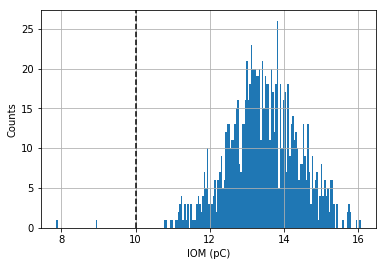

In [15]:
iom_limit = 10

plt.figure()
plt.hist(df["iom_intensity_pc"], bins=200)
plt.axvline(iom_limit, color='k', linestyle='--')
plt.xlabel("IOM (pC)")
plt.ylabel("Counts")
plt.grid(True)
plt.show()

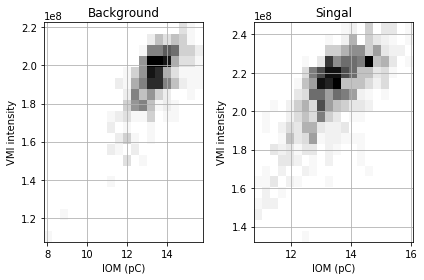

In [16]:
bg_period, bg_mod = 3, 0  # Confirm this parameters!
df["is_bg"] = df["tag"] % bg_period == bg_mod

plt.figure()
plt.subplot(121)
where = df["is_bg"]
plt.hist2d(df[where]["iom_intensity_pc"],
           df[where]["img_intensity"], bins=[20, 20], cmap="Greys")
plt.title("Background")
plt.xlabel("IOM (pC)")
plt.ylabel("VMI intensity")
plt.grid(True)

plt.subplot(122)
where = ~df["is_bg"]
plt.hist2d(df[where]["iom_intensity_pc"],
           df[where]["img_intensity"], bins=[20, 20], cmap="Greys")
plt.title("Singal")
plt.xlabel("IOM (pC)")
plt.ylabel("VMI intensity")
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
def read_img(filename, tag_offset = None):
    if tag_offset is None:
        where = slice(None)
    else:
        where = slice(tag_offset, None)

    with File(filename, 'r') as f:
        try:
            for tag, img, iom, dt, y in zip(
                f['/bunches'][where],
                f['/vmi/andor'],
                f['/photon_diagnostics/FEL01/I0_monitor/iom_sh_a_pc'][where],
                f['/user_laser/delay_line/position'][where],
                f["/photon_diagnostics/Spectrometer/hor_spectrum"][where],
            ):
                yield {
                    'tag': tag,
                    'img': img.astype('double'),
                    'iom': iom,
                    'delay_float': dt,
                    'atmax_float': y.argmax(),
                }
        except KeyError:
            return
        

def bin_delays(d):
    step = 0.02  # Check delay step!
    centers = np.arange(-10, 0, step)
    bins = (centers[1:] + centers[:-1]) / 2
    return centers.item(np.digitize(d, bins=bins))


def bin_atmax(d):
    step = 5  # Check delay step!
    centers = np.arange(0, 1000, step)
    bins = (centers[1:] + centers[:-1]) / 2
    return centers.item(np.digitize(d, bins=bins))


def sumup_images(it):
    df = pd.DataFrame(list(it))
    where = iom_limit < df['iom']
    df['delay'] = df['delay_float'].apply(bin_delays)
    df['atmax'] = df['atmax_float'].apply(bin_atmax)
    df["is_bg"] = df["tag"] % bg_period == bg_mod
#     grouped = df[where].groupby(['is_bg', 'delay', 'atmax'])['img']
    grouped = df[where].groupby(['is_bg', 'delay'])['img']
    return pd.DataFrame({
        'sum': grouped.apply(sum),
        'count': grouped.count(),
    })

In [22]:
reduced = partial(reduce, partial(pd.DataFrame.add, fill_value=0))

# with ProgressBar():
#     summed = (
#         from_sequence(filenames[10:])
#         .map(read_img, tag_offset=tag_offset)
#         .flatten()
#         .reduction(sumup_images, reduced)
#         .compute()
#     )

with ProgressBar():
    summed = (
        from_sequence(filenames[:10])
        .map(read_img, tag_offset=tag_offset)
        .flatten()
        .compute()
#         .map(sumup_images)
#         .reduction(reduced, reduced)
#         .compute()
    )
summed

[########################################] | 100% Completed | 27.4s


[{'tag': 488211201, 'img': array([[102., 103., 109., ..., 120., 124., 116.],
         [113., 106., 110., ..., 113., 113., 115.],
         [105., 105.,  97., ..., 114., 115., 118.],
         ...,
         [ 99., 108., 102., ..., 116., 106., 100.],
         [100., 109., 103., ..., 106., 105., 109.],
         [106., 105.,  99., ..., 107., 112.,  98.]]), 'iom': 13.839340209960938, 'delay_float': -7.599797592831095, 'atmax_float': 591},
 {'tag': 488211202, 'img': array([[107.,  98., 105., ..., 112., 119., 110.],
         [112., 102., 107., ..., 118., 115., 113.],
         [112., 107.,  98., ..., 109., 111., 119.],
         ...,
         [105., 110., 105., ..., 110.,  97., 103.],
         [104., 100., 107., ..., 107., 103., 106.],
         [107., 103., 102., ..., 105., 109.,  99.]]), 'iom': 12.51068115234375, 'delay_float': -7.599797592831095, 'atmax_float': 613},
 {'tag': 488211203, 'img': array([[100., 102., 107., ..., 114., 119., 115.],
         [102., 106., 103., ..., 113., 103., 114.],


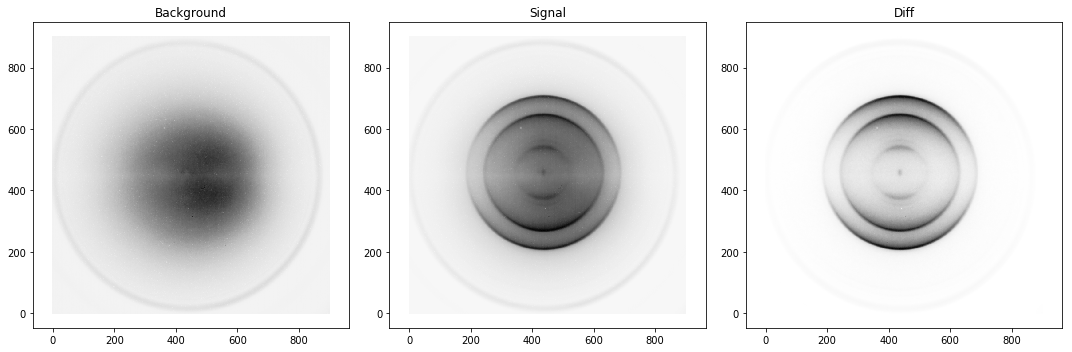

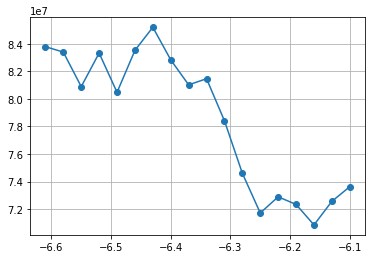

In [10]:
avg = [
{'delay': k,
 'bg_n': summed.loc[(k, True), 'count'],
 'bg_img': summed.loc[(k, True), 'summed'] / summed.loc[(k, True), 'count'],
 'sg_n': summed.loc[(k, False), 'count'],
 'sg_img': summed.loc[(k, False), 'summed'] / summed.loc[(k, False), 'count'],
 'df_n': summed.loc[(k, False), 'count'],
 'df_img': (summed.loc[(k, False), 'summed'] / summed.loc[(k, False), 'count']
            - summed.loc[(k, True), 'summed'] / summed.loc[(k, True), 'count'])}
    for k in df["delay"].unique()
] 

    
for k, d in avg.items():
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.title("Background")
    plt.pcolormesh(d['bg_img'], cmap="Greys")
    plt.clim(0, None)
    plt.axis('equal')
    plt.subplot(132)
    plt.title("Signal")
    plt.pcolormesh(d['sg_img'], cmap="Greys")
    plt.clim(0, None)
    plt.axis('equal')
    plt.subplot(133)
    plt.title("Diff")
    plt.pcolormesh(d['df_img'], cmap="Greys")
    plt.clim(0, None)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    break

plt.figure()
plt.plot([k for k in avg], [d['df_img'].sum() for d in avg.values()], 'o-')
plt.grid(True)
plt.show()

In [11]:
# print(filenames)
writein = f"/data/Step501N2/Run_{run:03d}/work"

for k, d in avg.items():
    with File(f"{writein}/reduced_dt={k:.3f}.h5", "w") as f:
        f['delay'] = d['delay']
        f['bg_n'] = d['bg_n']
        f['bg_img'] = d['bg_img']
        f['sg_n'] = d['sg_n']
        f['sg_img'] = d['sg_img']
        f['df_n'] = d['df_n']
        f['df_img'] = d['df_img']